In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim.lr_scheduler as lr_scheduler
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch.nn.functional as F

In [2]:
mnist_train = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=Compose([Resize((32, 32)), ToTensor()])
)

mnist_test = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=Compose([Resize((32, 32)), ToTensor()])
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.85MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.49MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.9MB/s]


In [3]:
batch_size = 64

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size)

In [4]:
def mean_std(loader):
    sum, squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        sum += torch.mean(data, dim=[0, 2, 3])
        squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = sum / num_batches
    std = (squared_sum / num_batches - mean**2)**0.5
    return mean, std

mean, std = mean_std(mnist_train_loader)
print(mean)
print(std)

tensor([0.2856])
tensor([0.3385])


In [5]:
normalized_train = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=Compose([Resize((32, 32)), ToTensor(), Normalize((mean), (std))])
)

normalized_test = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=Compose([Resize((32, 32)), ToTensor(), Normalize((mean), (std))])
)

normalized_train_loader = DataLoader(mnist_train, batch_size=batch_size)
normalized_test_loader = DataLoader(mnist_test, batch_size=batch_size)

9


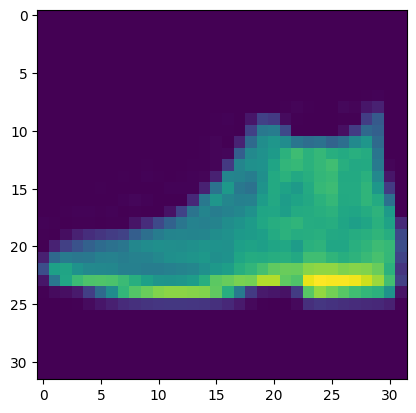

In [6]:
sample_image, sample_label = normalized_test[0]
resized_image = np.transpose(sample_image, (1, 2, 0)).reshape((32, 32))
plt.imshow(resized_image)
print(sample_label)

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(6),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.BatchNorm1d(84),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self.convolutional_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        x = F.softmax(x, dim=1)
        return x

In [8]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (8): ReLU()
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [11]:
epochs = 20
train_loss = []
val_loss = []
t_accuracy_gain = []
accuracy_gain = []

for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    total_t = 0

    for idx, (image, label) in enumerate(normalized_train_loader):
        optimizer.zero_grad()
        pred_t = model(image)

        loss = criterion(pred_t, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred_t = torch.nn.functional.softmax(pred_t, dim=1)
        for i, p in enumerate(pred_t):
            if label[i] == torch.max(p.data, 0)[1]:
                total_t += 1

    accuracy_t = total_t / len(normalized_train)
    t_accuracy_gain.append(accuracy_t)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    model.eval()
    total = 0
    for idx, (image, label) in enumerate(normalized_test_loader):
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total += 1

    accuracy = total / len(normalized_test)
    accuracy_gain.append(accuracy)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(
        epoch + 1, epochs, total_train_loss, total_val_loss, accuracy))


Epoch: 1/20, Train Loss: 1.6483, Val Loss: 1.6175, Val Acc: 0.8477

Epoch: 2/20, Train Loss: 1.5940, Val Loss: 1.6042, Val Acc: 0.8592

Epoch: 3/20, Train Loss: 1.5831, Val Loss: 1.5952, Val Acc: 0.8672

Epoch: 4/20, Train Loss: 1.5755, Val Loss: 1.5953, Val Acc: 0.8648

Epoch: 5/20, Train Loss: 1.5694, Val Loss: 1.5862, Val Acc: 0.8738

Epoch: 6/20, Train Loss: 1.5652, Val Loss: 1.5812, Val Acc: 0.8797

Epoch: 7/20, Train Loss: 1.5604, Val Loss: 1.5769, Val Acc: 0.8847

Epoch: 8/20, Train Loss: 1.5583, Val Loss: 1.5762, Val Acc: 0.8852

Epoch: 9/20, Train Loss: 1.5552, Val Loss: 1.5772, Val Acc: 0.8838

Epoch: 10/20, Train Loss: 1.5557, Val Loss: 1.5809, Val Acc: 0.8787

Epoch: 11/20, Train Loss: 1.5500, Val Loss: 1.5744, Val Acc: 0.8863

Epoch: 12/20, Train Loss: 1.5497, Val Loss: 1.5666, Val Acc: 0.8942

Epoch: 13/20, Train Loss: 1.5488, Val Loss: 1.5664, Val Acc: 0.8939

Epoch: 14/20, Train Loss: 1.5454, Val Loss: 1.5691, Val Acc: 0.8904

Epoch: 15/20, Train Loss: 1.5440, Val Loss